In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [0]:
def loadData():
    with np.load('notMNIST.npz') as data :
        Data, Target = data ['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

In [0]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainData = trainData.reshape(3500,784)
validData = validData.reshape(100,784)
testData = testData.reshape(145,784)

In [0]:
def accuracySGD(predictions, labels):
    return (np.sum((predictions>=0.5)==labels) / np.shape(predictions)[0])

In [0]:
epochs = 700
batch_size = 500
l_r = 0.001
b1 = None
b2 = None
e = 10e-4

In [0]:
def buildGraph(beta1 = None, beta2 = None, epsilon = None, lossType=None, learning_rate = None):
    num_batches = int(3500/batch_size)
    lbda = 0
    graph = tf.Graph()
  
    with graph.as_default():
        W = tf.truncated_normal(shape=(784, 1), mean=0.0, stddev=0.5, dtype=tf.float32)
        W = tf.Variable(W)
        b = tf.zeros(1)
        b = tf.Variable(b)

        x = tf.placeholder(tf.float32, shape=(batch_size, 784))
        y = tf.placeholder(tf.float32, shape=(batch_size, 1))

        v_x = tf.placeholder(tf.float32, shape=(len(validData), 784))
        v_y = tf.placeholder(tf.int8, shape=(len(validTarget), 1))

        t_x = tf.placeholder(tf.float32, shape=(len(testData), 784))
        t_y = tf.placeholder(tf.int8, shape=(len(testTarget), 1))

        tf.set_random_seed(421)

        if lossType == "MSE":
            z = tf.matmul(x,W) + b
            loss = tf.losses.mean_squared_error(y, z)
            reg = tf.nn.l2_loss(W)
            loss += (lbda/2.0)*reg

            v_z = tf.matmul(v_x,W) + b
            vloss = tf.losses.mean_squared_error(v_y, v_z)
            vloss += (lbda/2.0)*reg

            t_z = tf.matmul(t_x,W) + b
            tloss = tf.losses.mean_squared_error(t_y, t_z)
            tloss += (lbda/2.0)*reg

            optimizer = tf.train.AdamOptimizer(learning_rate = 0.001, beta1 = 0.95).minimize(loss)

        elif lossType == "CE":
            z = tf.sigmoid(tf.matmul(x,W) + b)
            loss = tf.losses.sigmoid_cross_entropy(y, z)
            reg = tf.nn.l2_loss(W)
            loss += (lbda/2.0)*reg

            v_z = tf.sigmoid(tf.matmul(v_x,W) + b)
            vloss = tf.losses.sigmoid_cross_entropy(v_y, v_z)
            vloss += (lbda/2.0)*reg

            t_z = tf.sigmoid(tf.matmul(t_x,W) + b)
            tloss = tf.losses.sigmoid_cross_entropy(t_y, t_z)
            tloss += (lbda/2.0)*reg

            optimizer = tf.train.AdamOptimizer(learning_rate = 0.001, epsilon = 1e-04).minimize(loss)

        with tf.Session(graph=graph) as session:
            tf.global_variables_initializer().run()
            training_loss = []
            validation_loss = []
            testing_loss = []
            training_accuracy = []
            validation_accuracy = []
            testing_accuracy = []
            for epoch in range(epochs):
                total_loss = 0
                for n in range(num_batches):
                    x_batch = trainData[n*batch_size:(n+1)*batch_size,]
                    y_batch = trainTarget[n*batch_size:(n+1)*batch_size,]
                    _, opt_W, opt_b, train_loss, pred, v_loss, v_pred, t_loss, t_pred = session.run([optimizer, W, b, loss, z, vloss, v_z, tloss, t_z], 
                                                                                                                      {x: x_batch, 
                                                                                                                       y: y_batch,
                                                                                                                       v_x: validData,
                                                                                                                       v_y: validTarget,
                                                                                                                         t_x: testData,
                                                                                                                       t_y: testTarget})
                if (n % 1 == 0):
                    training_loss += [train_loss]
                    t_accuracy = accuracySGD(pred, y_batch)
                    training_accuracy += [t_accuracy]
                    validation_loss += [v_loss]
                    v_accuracy = accuracySGD(v_pred, validTarget)
                    validation_accuracy += [v_accuracy]
                    testing_loss += [t_loss]
                    t_accuracy = accuracySGD(t_pred, testTarget)
                    testing_accuracy += [t_accuracy]

                    print('Epoch: {}, Training Loss: {}, Training Accuracy: {}'.format(epoch, train_loss, t_accuracy))
                    print('Epoch: {}, Validation Loss: {}, Validation Accuracy: {}'.format(epoch, v_loss, v_accuracy))
                    print('Epoch: {}, Testing Loss: {}, Testing Accuracy: {}'.format(epoch, t_loss, t_accuracy))

    # Your implementation here
    return opt_W, opt_b, (pred>=0.5), trainTarget, train_loss, optimizer, reg, training_loss, training_accuracy, validation_loss, validation_accuracy, testing_loss, testing_accuracy

In [0]:
opt_W, opt_b, pred, trainTarget, train_loss, optimizer, reg, training_loss, training_accuracy, validation_loss, validation_accuracy, testing_loss, testing_accuracy = buildGraph(lossType = "CE")

Epoch: 0, Training Loss: 0.7045921087265015, Training Accuracy: 0.5310344827586206
Epoch: 0, Validation Loss: 0.7427818179130554, Validation Accuracy: 0.61
Epoch: 0, Testing Loss: 0.8024340271949768, Testing Accuracy: 0.5310344827586206
Epoch: 1, Training Loss: 0.6750874519348145, Training Accuracy: 0.5862068965517241
Epoch: 1, Validation Loss: 0.7146576046943665, Validation Accuracy: 0.6
Epoch: 1, Testing Loss: 0.7543880343437195, Testing Accuracy: 0.5862068965517241
Epoch: 2, Training Loss: 0.6443548798561096, Training Accuracy: 0.6827586206896552
Epoch: 2, Validation Loss: 0.6718742251396179, Validation Accuracy: 0.69
Epoch: 2, Testing Loss: 0.7034984827041626, Testing Accuracy: 0.6827586206896552
Epoch: 3, Training Loss: 0.6148713231086731, Training Accuracy: 0.7310344827586207
Epoch: 3, Validation Loss: 0.6342689394950867, Validation Accuracy: 0.77
Epoch: 3, Testing Loss: 0.6609775424003601, Testing Accuracy: 0.7310344827586207
Epoch: 4, Training Loss: 0.587871789932251, Training 

In [0]:
def plotting_loss(epoch, training_error, validation_error, testing_error, title):
    epoch_idx = np.arange(0, epoch)
    plt.figure(figsize=(10,10))
    plt.plot(epoch_idx,training_error)
    plt.plot(epoch_idx,validation_error)
    plt.plot(epoch_idx,testing_error)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training Loss', 'Validation Loss', 'Testing Loss'])
    plt.title(title)
    plt.show()

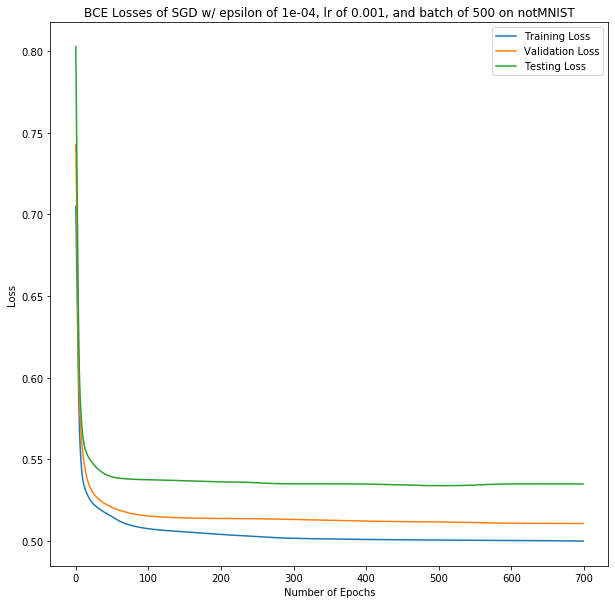

In [0]:
plotting_loss(epochs, training_loss, validation_loss, testing_loss,"BCE Losses of SGD w/ epsilon of 1e-04, lr of 0.001, and batch of 500 on notMNIST")

In [0]:
def plotting_accuracy(epoch, training_accuracy, validation_accuracy, testing_accuracy, title):
    epoch_idx = np.arange(0, epoch)
    plt.figure(figsize=(10,10))
    plt.plot(epoch_idx,training_accuracy)
    plt.plot(epoch_idx,validation_accuracy)
    plt.plot(epoch_idx,testing_accuracy)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training Accuracy', 'Validation Accuracy', 'Testing Accuracy'])
    plt.title(title)
    plt.show()

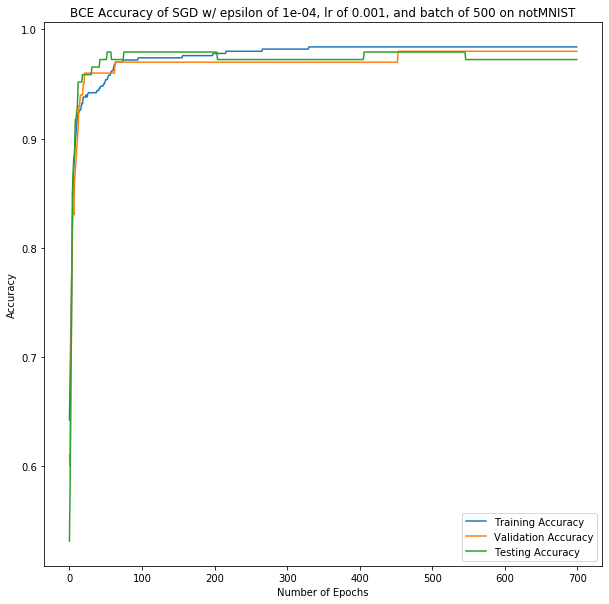

In [0]:
plotting_accuracy(epochs, training_accuracy, validation_accuracy, testing_accuracy, "BCE Accuracy of SGD w/ epsilon of 1e-04, lr of 0.001, and batch of 500 on notMNIST")